In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime 
import time 

import numpy as np

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMeans 
import math
import pickle
import os


import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [3]:
data = pd.read_csv("E:/GSU_Study/COURSE_SCHEDULE/Fall-24/Graph Analytics/project/train.csv")

In [4]:
g = nx.from_pandas_edgelist(data, 'source_node', 'destination_node', create_using=nx.DiGraph())

In [5]:
print(g)

DiGraph with 1862220 nodes and 9437519 edges


In [9]:
print("The number of unique users: ",len(g.nodes()))

The number of unique users:  1862220


Number of followers

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of Datapoints Have a Follower Count of 40: This suggests a heavily skewed distribution. Most users (99%) have 40 or fewer followers. It implies that the vast majority of users have relatively few followers.

In [13]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


As you move towards the 100th percentile, the follower counts increase significantly. This shows that a very small percentage of users have a disproportionately large number of followers. For instance, at the 100th percentile, the maximum follower count is 552, but this is an extreme and not representative of the general user base.

Number of people each user is following

In [14]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
or i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


90th percentile value being 12 means that 90% of the users follow 12 or fewer other users

In [16]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


While 99% of users follow 40 or fewer people, the maximum outdegree at the 100th percentile is 1,566. This suggests that a very small fraction of users follow a significantly larger number of others.

**Both indegree and outdegree distributions appear to be heavily skewed, with the vast majority of users having relatively few connections, and a very small number of users having a large number of connections. This is typical of many social networks and is often described by a power-law.**


**The power law means that the vast majority of nodes have very few connections, while a few important nodes (we call them Hubs) have a huge number of connections.**

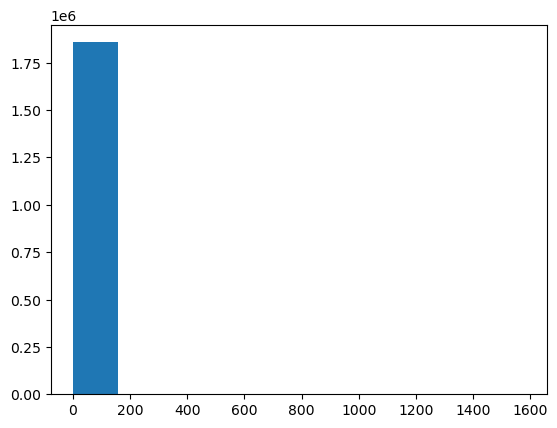

In [17]:
# Degree Distribution
degrees = [g.degree(n) for n in g.nodes()]
plt.hist(degrees)
plt.show()

The majority of nodes have a very low degree (close to 0), as indicated by the tall bar on the far left.

As the degree increases, the number of nodes decreases dramatically. This is evidenced by the absence of bars beyond the degree of 0 on the x-axis.

However, the y-axis indicates that the count of nodes with degree 0 is of the order of 1 million (1e6).
The interpretation of this graph is that your network is sparse and that most nodes have very few connections.

This is a common characteristic of real-world networks, where many nodes have a small number of connections, and a few nodes have a large number of connections

In [18]:
density = nx.density(g)
print(f"Density of the graph: {density}")

Density of the graph: 2.7214233013742145e-06


**Graph density measures how many edges are in the graph compared to the maximum possible number of edges.
A density of approximately 0.0000027 is very low, which is typical for large social networks. It suggests that, on average, each node (user) is connected to a very small fraction of the total possible nodes they could be connected to. This is characteristic of sparse networks where most users are connected to only a few others.**

In [20]:
#Assortativity
assortativity = nx.degree_assortativity_coefficient(g)
print(f"Assortativity of the graph: {assortativity}")

Assortativity of the graph: 0.42325271339369375


Assortativity measures the tendency of nodes to connect with other nodes that are similar or different in some way. In the context of social networks, it often refers to degree assortativity, which measures the tendency of nodes to connect with others that have a similar number of connections (degree).

**A value of 0.42 indicates a moderate level of assortativity. This suggests that users in this network tend to connect with other users who have a similar number of connections. This is common in social networks, where, for example, popular users (those with many connections) are more likely to connect with other popular users.**

In [21]:
import networkx as nx
strongly_connected = list(nx.strongly_connected_components(g))
print(f"Number of strongly connected components: {len(strongly_connected)}")

weakly_connected = list(nx.weakly_connected_components(g))
print(f"Number of weakly connected components: {len(weakly_connected)}")


Number of strongly connected components: 527748
Number of weakly connected components: 45558


Common approach is to calculate the average path length over the largest weakly connected component (LWCC). This is because, in the largest weakly connected component, each node is reachable from every other node if the direction of edges is ignored.

In [23]:
import networkx as nx
import random

# Convert the graph to its undirected version for path length calculations
g_undirected = g.to_undirected()

# Number of random samples (the higher, the more accurate but slower it will be)
num_samples = 1000 

# Convert nodes to a list for sampling
nodes = list(g_undirected.nodes())

# Randomly sample node pairs and calculate their shortest path
path_lengths = []
for _ in range(num_samples):
    # Pick two random nodes
    node1, node2 = random.sample(nodes, 2)
    
    # Try to find the shortest path between them
    try:
        path_length = nx.shortest_path_length(g_undirected, source=node1, target=node2)
        path_lengths.append(path_length)
    except nx.NetworkXNoPath:
        # If there is no path between the nodes, we can either skip it or handle it somehow
        continue

# Calculate the average path length based on the sampled paths
if path_lengths:
    average_path_length = sum(path_lengths) / len(path_lengths)
    print(f"Estimated average path length (based on {num_samples} samples): {average_path_length}")
else:
    print("No paths found in the samples taken.")


Estimated average path length (based on 1000 samples): 7.496567505720824


The average path length is the average number of steps along the shortest paths for all possible pairs of network nodes. It's a measure of the average distance between nodes in the graph.

**An estimated average path length of about 7.49 indicates that on average, any user can reach another user through approximately 7.49 steps (connections). This aligns with the concept of "six degrees of separation" in social networks, suggesting that the network has a relatively small-world property, where even though the network is large and sparse, paths connecting users are relatively short.**

SUMMARY:

The graph is sparse, as indicated by its low density, which is typical for social media networks

The moderate positive assortativity suggests that users tend to connect with others who have a similar number of connections

The estimated average path length suggests that despite its size and sparseness, the network has relatively short paths between users, characteristic of a small-world network

In [24]:
# Degree Centrality

# Calculate degree centrality
degree_centrality = nx.degree_centrality(g)

# Find the node with the highest degree centrality
most_popular_node = max(degree_centrality, key=degree_centrality.get)
most_popular_centrality = degree_centrality[most_popular_node]

# Display the most popular node and its centrality value
print(f"Node with the highest degree centrality: {most_popular_node}")
print(f"Degree centrality of this node: {most_popular_centrality}")



Node with the highest degree centrality: 1492489
Degree centrality of this node: 0.0008479131616635851


**Degree Centrality: Measures the number of connections a node has. In social media, a user with high degree centrality would be someone who follows many others (outdegree) or is followed by many others (indegree). This is often a basic indicator of popularity or activity.**

In [25]:
# Calculate PageRank
pagerank = nx.pagerank(g, tol=1e-04)

# Sort nodes by PageRank and select the top 5
top_5_pagerank_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

# Display top 5 nodes with highest PageRank
print("Top 5 nodes with the highest PageRank:")
for node, rank in top_5_pagerank_nodes:
    print(f"Node {node}: PageRank = {rank}")

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(g, max_iter=50)

# Sort nodes by Eigenvector Centrality and select the top 5
top_5_eigenvector_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Display top 5 nodes with highest Eigenvector Centrality
print("\nTop 5 nodes with the highest Eigenvector Centrality:")
for node, centrality in top_5_eigenvector_nodes:
    print(f"Node {node}: Eigenvector Centrality = {centrality}")


Top 5 nodes with the highest PageRank:
Node 289584: PageRank = 2.688578764999046e-05
Node 1814036: PageRank = 2.5036157282512476e-05
Node 1380268: PageRank = 2.375895225073983e-05
Node 902162: PageRank = 2.203315046686652e-05
Node 1671845: PageRank = 1.6487236294574314e-05

Top 5 nodes with the highest Eigenvector Centrality:
Node 1742231: Eigenvector Centrality = 0.09486964384862467
Node 523335: Eigenvector Centrality = 0.0941391063189504
Node 1149308: Eigenvector Centrality = 0.09403731745964666
Node 1190227: Eigenvector Centrality = 0.0936743845627411
Node 1056843: Eigenvector Centrality = 0.09348979543623476


Eigenvector Centrality: Reflects the influence of a node based on the principle that connections to high-scoring nodes contribute more to the score of the node in question. On social media, this could identify not just users with many followers, but those whose followers are also influential.

PageRank: A variant of eigenvector centrality, PageRank considers the structure of the entire network when determining the importance of a node. It's useful in social networks to determine influential users, under the assumption that having connections to users who are themselves influential is a sign of higher importance



In [26]:

# Calculate Katz Centrality
# Note: Adjust alpha to ensure it's small enough for large graphs
katz_centrality = nx.katz_centrality(g, alpha=0.005, max_iter=1000, tol=1e-04)

# Sort nodes by Katz Centrality and select the top 5
top_5_katz_nodes = sorted(katz_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Display top 5 nodes with highest Katz Centrality
print("Top 5 nodes with the highest Katz Centrality:")
for node, centrality in top_5_katz_nodes:
    print(f"Node {node}: Katz Centrality = {centrality}")



Top 5 nodes with the highest Katz Centrality:
Node 1742231: Katz Centrality = 0.004764500149743395
Node 1190227: Katz Centrality = 0.00474137779169021
Node 1056843: Katz Centrality = 0.004730973534304364
Node 1149308: Katz Centrality = 0.004643101170890415
Node 523335: Katz Centrality = 0.004578081245599146


**Katz Centrality: Similar to eigenvector centrality, but it also takes into account the number of all paths leading to a node, exponentially damped by length to give higher weight to shorter paths. It can be useful for social media networks where all types of direct and indirect influence are of interest.**

In [27]:
Adj = nx.adjacency_matrix(g,nodelist=sorted(g.nodes()))
Adj

<1862220x1862220 sparse array of type '<class 'numpy.intc'>'
	with 9437519 stored elements in Compressed Sparse Row format>

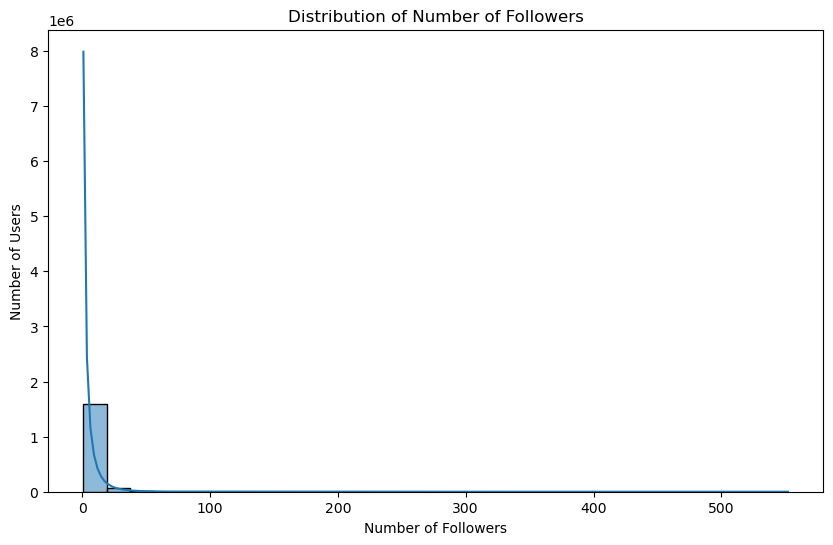

In [28]:
followers_count = df['destination_node'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(followers_count, bins=30, kde=True)
plt.title('Distribution of Number of Followers')
plt.xlabel('Number of Followers')
plt.ylabel('Number of Users')
plt.show()



The chart depicts the distribution of followers among users on a platform. The majority of users possess a limited number of followers, whereas a minimal segment boasts a significant follower count

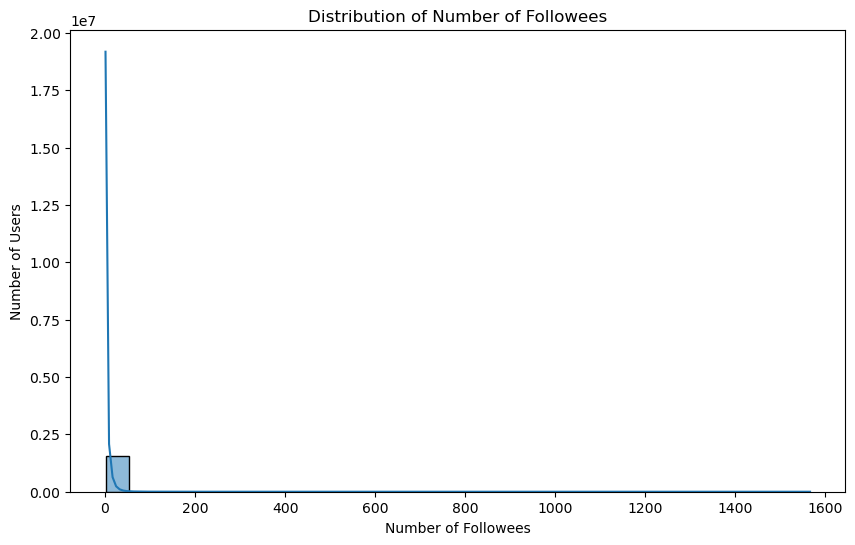

In [29]:
# Distribution of Number of Followees
followees_count = df['source_node'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(followees_count, bins=30, kde=True)
plt.title('Distribution of Number of Followees')
plt.xlabel('Number of Followees')
plt.ylabel('Number of Users')
plt.show()

The chart shows the distribution of how many people users follow. Most users follow only a few people, while a very small number of users follow many people. This pattern is common in social networks where the majority have a few connections, and only a few have a lot.






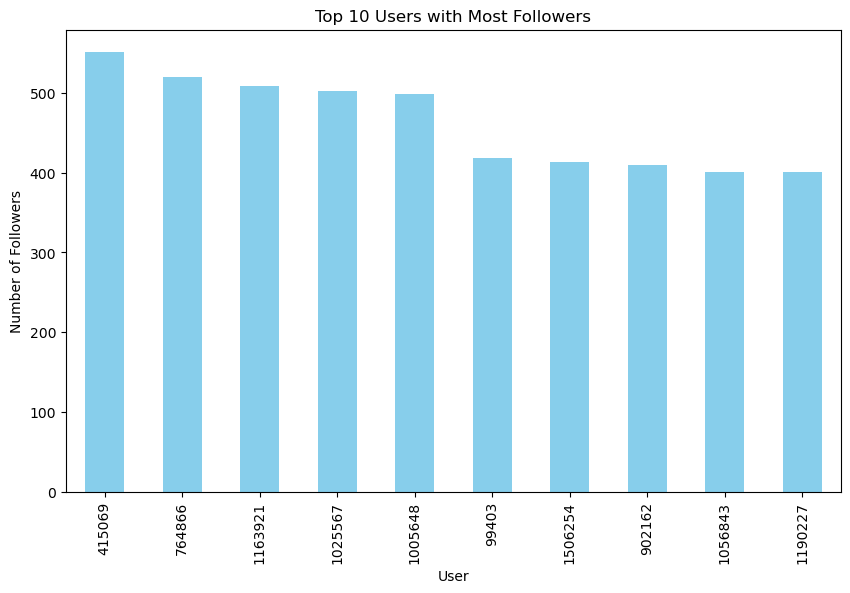

In [30]:
top_followers = followers_count.head(10)
plt.figure(figsize=(10, 6))
top_followers.plot(kind='bar', color='skyblue')
plt.title('Top 10 Users with Most Followers')
plt.xlabel('User')
plt.ylabel('Number of Followers')
plt.show()

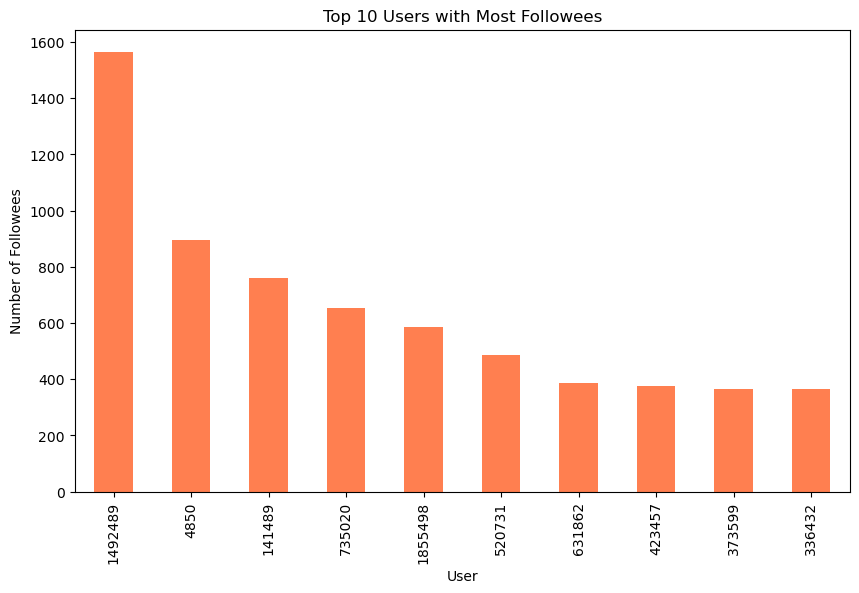

In [31]:
top_followees = followees_count.head(10)
plt.figure(figsize=(10, 6))
top_followees.plot(kind='bar', color='coral')
plt.title('Top 10 Users with Most Followees')
plt.xlabel('User')
plt.ylabel('Number of Followees')
plt.show()

In [32]:
avg_followers = np.mean(followers_count)
print(f"Average number of followers: {avg_followers:.2f}")

Average number of followers: 5.64


In [34]:
centrality = nx.degree_centrality(g)
# Get the node with the highest centrality
max_centrality_node = max(centrality, key=centrality.get)
print(f"Node with highest centrality: {max_centrality_node}")

Node with highest centrality: 1492489


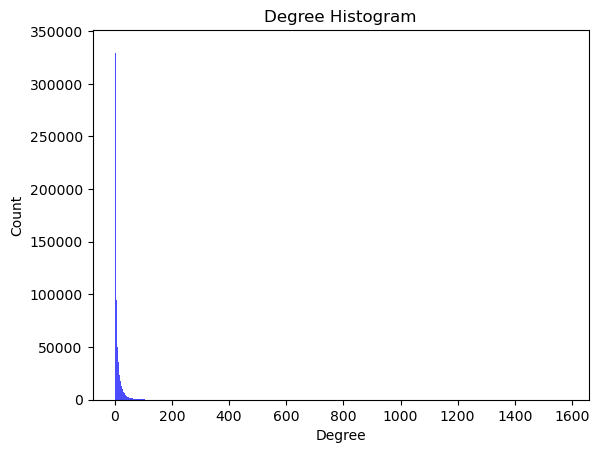

In [36]:
import matplotlib.pyplot as plt
import networkx as nx

degrees = dict(g.degree())  # This works for both directed and undirected graphs

# Since the graph is undirected, there's no separate in-degree or out-degree
degree_centrality = nx.degree_centrality(g)  # Degree centrality calculation is the same for both

plt.hist(degrees.values(), bins=range(1, max(degrees.values()) + 1), color='blue', alpha=0.7)
plt.title('Degree Histogram')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()



Degree Centrality indicates how popular or central a person is in the network, based on their number of friends. The image shows that most people are connected to only a few others, with very few people connected to many others

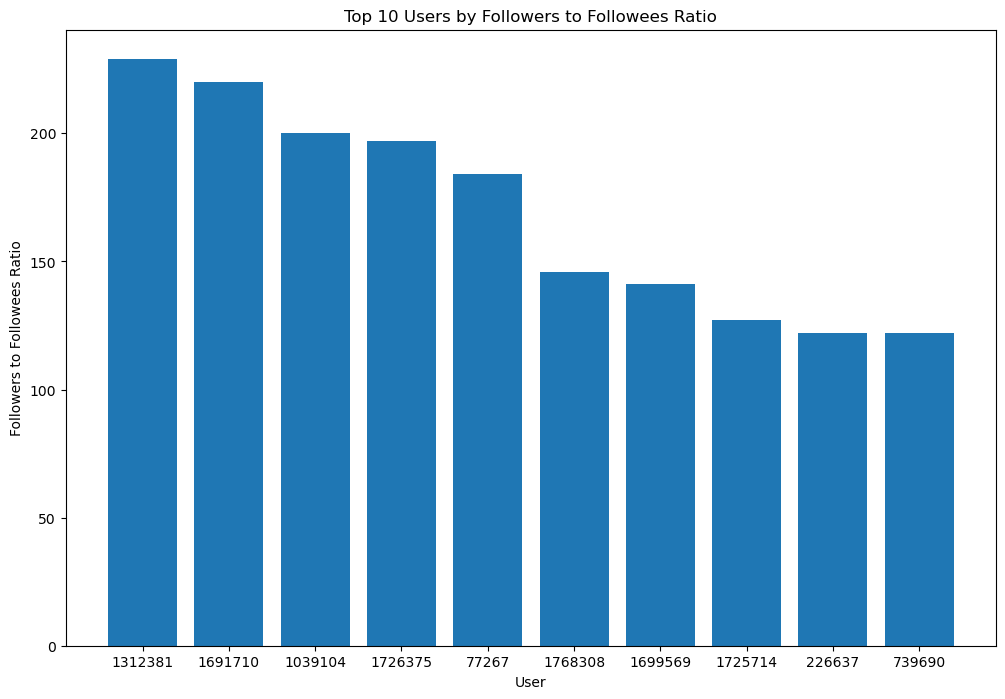

In [38]:
ratio = {node: followers_count.get(node, 0) / followees_count.get(node, 1) for node in followees_count.index}
# Convert to a list of tuples and sort
sorted_ratio = sorted(ratio.items(), key=lambda item: item[1], reverse=True)

# Plotting the ratio for the top 10 users
plt.figure(figsize=(12, 8))
plt.bar(range(10), [val[1] for val in sorted_ratio[:10]], tick_label=[val[0] for val in sorted_ratio[:10]])
plt.title('Top 10 Users by Followers to Followees Ratio')
plt.xlabel('User')
plt.ylabel('Followers to Followees Ratio')
plt.show()

The bar chart represents the top 10 users in a social network based on their followers-to-followees ratio. It shows that user 1312381 has the highest ratio, indicating they have many more followers compared to the number of people they follow, suggesting high popularity or influence within the network. The other users listed also have significantly more followers than followees, but to a slightly lesser extent than the top user.

In [41]:
sample_size = 100 
sampled_nodes = random.sample(list(g.nodes()), sample_size)



In [42]:
subG = g.subgraph(sampled_nodes)

In [43]:

for source_node in subG.nodes():
    shortest_paths_lengths = nx.single_source_shortest_path_length(subG, source_node)
    for target_node, length in shortest_paths_lengths.items():
        print(f"Shortest path from node {source_node} to node {target_node} has a length of {length}")



Shortest path from node 1563143 to node 1563143 has a length of 0
Shortest path from node 1333775 to node 1333775 has a length of 0
Shortest path from node 1404948 to node 1404948 has a length of 0
Shortest path from node 1267221 to node 1267221 has a length of 0
Shortest path from node 1625109 to node 1625109 has a length of 0
Shortest path from node 486935 to node 486935 has a length of 0
Shortest path from node 448535 to node 448535 has a length of 0
Shortest path from node 467487 to node 467487 has a length of 0
Shortest path from node 1853992 to node 1853992 has a length of 0
Shortest path from node 874027 to node 874027 has a length of 0
Shortest path from node 376369 to node 376369 has a length of 0
Shortest path from node 1719354 to node 1719354 has a length of 0
Shortest path from node 1139773 to node 1139773 has a length of 0
Shortest path from node 511040 to node 511040 has a length of 0
Shortest path from node 1312332 to node 1312332 has a length of 0
Shortest path from nod

**PREPROCESSING**

In [47]:
# Identify isolated nodes
isolated_nodes = list(nx.isolates(g))
# Count of isolated nodes
num_isolated_nodes = len(isolated_nodes)

# Remove isolated nodes if they exist
if num_isolated_nodes > 0:
    g.remove_nodes_from(isolated_nodes)

# Display the number of isolated nodes removed
num_isolated_nodes

0

There were no isolated nodes within this network so none are being removed.

In [48]:
# Identify self-loops in the graph
self_loops = list(nx.selfloop_edges(g))

# Count of self-loops
num_self_loops = len(self_loops)

# Remove self-loops if they exist
if num_self_loops > 0:
    g.remove_edges_from(self_loops)

# Display the number of self-loops removed
num_self_loops

0

There were no self-loops (edges that connect nodes to themselves) in your graph, so no self-loops were removed.